# Random Forests

- use scikit-learn for **random forests**
- do **ordinal encoding** with high-cardinality categoricals
- understand how categorical encodings affect trees differently compared to linear models
- understand how tree ensembles reduce overfitting compared to a single decision tree with unlimited depth

In [1]:
%%capture

import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '/Users/keila/Documents/Lambda/Units_Git/DS-Unit-2-Kaggle-Challenge/data/'

In [34]:
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# I. Wrangle Data

In [22]:
def wrangle(fm_path, tv_path=None):
  # Import CSV files
  if tv_path:
    df = pd.merge(pd.read_csv(fm_path, 
                              na_values=[0, -2.000000e-08], 
                              parse_dates = ['construction_year', 'date_recorded']), 
                  pd.read_csv(tv_path)).set_index('id')
  else:
    df = pd.read_csv(fm_path, na_values=[0, -2.000000e-08], 
                     parse_dates = ['construction_year', 'date_recorded']).set_index('id')

  # Feature Engineering (Credit: Mena and Keila)
  df['pump_age'] = df['date_recorded'].dt.year - df['construction_year'].dt.year

  # Drop constant and repeated columns
  df.drop(columns=['recorded_by', 'extraction_type_group', 'quantity_group', 'date_recorded', 'construction_year'], 
          inplace=True)
  
  # Drop columns with high % of NaN values
  df.dropna(axis=1, thresh=len(df)*0.6, inplace = True)

  return df

df = wrangle(fm_path=DATA_PATH+'waterpumps/train_features.csv',
             tv_path=DATA_PATH+'waterpumps/train_labels.csv')

X_test = wrangle(fm_path=DATA_PATH+'waterpumps/test_features.csv')

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 59399 entries, 69572.0 to 26348.0
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   funder                 54987 non-null  object 
 1   gps_height             38962 non-null  float64
 2   installer              54967 non-null  object 
 3   longitude              57587 non-null  float64
 4   latitude               57587 non-null  float64
 5   wpt_name               59399 non-null  object 
 6   basin                  59399 non-null  object 
 7   subvillage             59028 non-null  object 
 8   region                 59399 non-null  object 
 9   region_code            59399 non-null  int64  
 10  district_code          59376 non-null  float64
 11  lga                    59399 non-null  object 
 12  ward                   59399 non-null  object 
 13  population             38019 non-null  float64
 14  public_meeting         56066 non-null  objec

# II. Split Data

## Split TV from FM

In [24]:
target = 'status_group'
y = df[target]
X = df.drop(columns=target)

# Training-Validation Split

- Randomized split

In [25]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Sanity check
assert len(X_train) + len(X_val) == len(X)

# III. Establish Baseline

This is a **classification** problem, our baseline will be **accuracy**. 

In [26]:
print('Baseline Accuracy:', y_train.value_counts(normalize=True).max())

Baseline Accuracy: 0.5425829668132747


# IV. Build Model(s)

- Missing values
- Categorical values

In [27]:
tree_model = make_pipeline(OrdinalEncoder(), # No OHE for high-cardinality categorical features with trees
                           SimpleImputer(strategy = 'median'),
                           DecisionTreeClassifier(random_state = 42)
                           )

tree_model.fit(X_train, y_train);

In [68]:
rf_model = make_pipeline(OrdinalEncoder(),
                         SimpleImputer(strategy= 'median'),
                         RandomForestClassifier(random_state=42,
                                                n_jobs = -1,
                                                max_samples = 0.7,
                                                max_depth = 20))

rf_model.fit(X_train, y_train);

# V. Check Metrics

In [28]:
print('TREE: Training Accuracy:', tree_model.score(X_train, y_train))
print('TREE: Validation Accuracy:', tree_model.score(X_val, y_val))

TREE: Training Accuracy: 0.9999579115722133
TREE: Validation Accuracy: 0.7102693602693603


In [69]:
print('FOREST: Training Accuracy:', rf_model.score(X_train, y_train))
print('FOREST: Validation Accuracy:', rf_model.score(X_val, y_val))

FOREST: Training Accuracy: 0.9446326732464909
FOREST: Validation Accuracy: 0.8095959595959596


# VI. Tune Model

More depth -> more flexibility -> possibly more overfitting

Hyperparameters that start with **max**:
- Increase flexibility as they get larger



Hyperparamaeter that start with **min**:
- Less flexible as they get larger

**Finding best max_sample**

In [35]:
samples = np.arange(0.2, 1, 0.1)

train_acc = []
val_acc = []

for sample in samples:
  tree_model = make_pipeline(
      OrdinalEncoder(),
      SimpleImputer(strategy='mean'),
      RandomForestClassifier(n_estimators=25,
                             n_jobs=-1,
                             random_state=42,
                             max_samples=sample)
  )
  tree_model.fit(X_train, y_train)

  train_acc.append(tree_model.score(X_train, y_train))
  val_acc.append(tree_model.score(X_val, y_val))

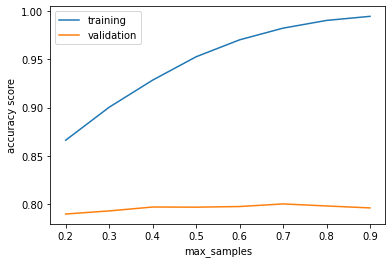

In [36]:
plt.plot(samples, train_acc, label='training')
plt.plot(samples, val_acc, label='validation')
plt.xlabel('max_samples')
plt.ylabel('accuracy score')
plt.legend();

**Finding best max_depth**

In [41]:
depths = range(2, 42, 2)

train_acc = []
val_acc = []

for depth in depths:
  tree_model = make_pipeline(
      OrdinalEncoder(),
      SimpleImputer(strategy='mean'),
      RandomForestClassifier(n_estimators=25,
                             n_jobs=-1,
                             random_state=42,
                             max_depth = depth)
  )
  tree_model.fit(X_train, y_train)

  train_acc.append(tree_model.score(X_train, y_train))
  val_acc.append(tree_model.score(X_val, y_val))

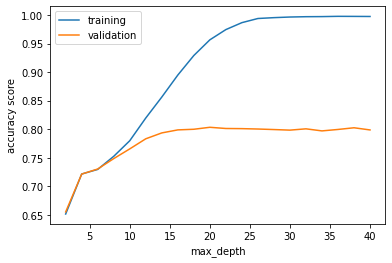

In [42]:
plt.plot(depths, train_acc, label='training')
plt.plot(depths, val_acc, label='validation')
plt.xlabel('max_depth')
plt.ylabel('accuracy score')
plt.legend();

**Finding best max_features**

In [58]:
features = np.arange(0.1, 1, 0.1)

train_acc = []
val_acc = []

for feature in features:
  tree_model = make_pipeline(
      OrdinalEncoder(),
      SimpleImputer(strategy='mean'),
      RandomForestClassifier(n_estimators=25,
                             n_jobs=-1,
                             random_state=42,
                             max_features = feature)
  )
  tree_model.fit(X_train, y_train)

  train_acc.append(tree_model.score(X_train, y_train))
  val_acc.append(tree_model.score(X_val, y_val))

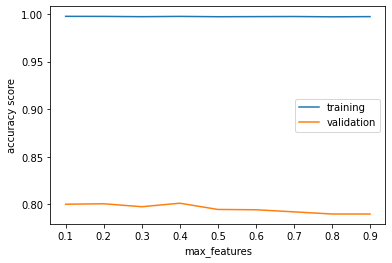

In [59]:
plt.plot(features, train_acc, label='training')
plt.plot(features, val_acc, label='validation')
plt.xlabel('max_features')
plt.ylabel('accuracy score')
plt.legend();

# VII. Communicate Results

The higher the Gini importance, the more responsible that feature is for reducing the impurity of the tree.

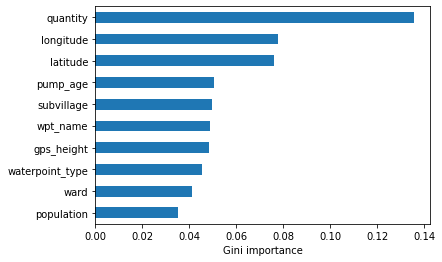

In [57]:
importances = rf_model.named_steps['randomforestclassifier'].feature_importances_
features = X_train.columns

feat_imp = pd.Series(importances, index = features).sort_values()
feat_imp.tail(10).plot(kind = 'barh')
plt.xlabel('Gini importance');